# Chapter 11 - Recap

## Binomial regression

In [1]:
library(rethinking)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

rethinking (Version 2.13)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




In [2]:
data(chimpanzees)
d <- chimpanzees

In [3]:
?chimpanzees

chimpanzees {rethinking},R Documentation


In [4]:
d$treatment <- 1 + d$prosoc_left + 2*d$condition

In [5]:
xtabs(~ treatment + prosoc_left + condition, d)

, , condition = 0

         prosoc_left
treatment   0   1
        1 126   0
        2   0 126
        3   0   0
        4   0   0

, , condition = 1

         prosoc_left
treatment   0   1
        1   0   0
        2   0   0
        3 126   0
        4   0 126


#### A first model definition with a "flat" prior for a

In [7]:
m11.1 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm(0, 10)
    ), data=d
)

`pulled_left` indicates that the chimp pulled the left handle.

#### Simulating from the prior

In [8]:
set.seed(1999)
prior <- extract.prior(m11.1, n=1e4)

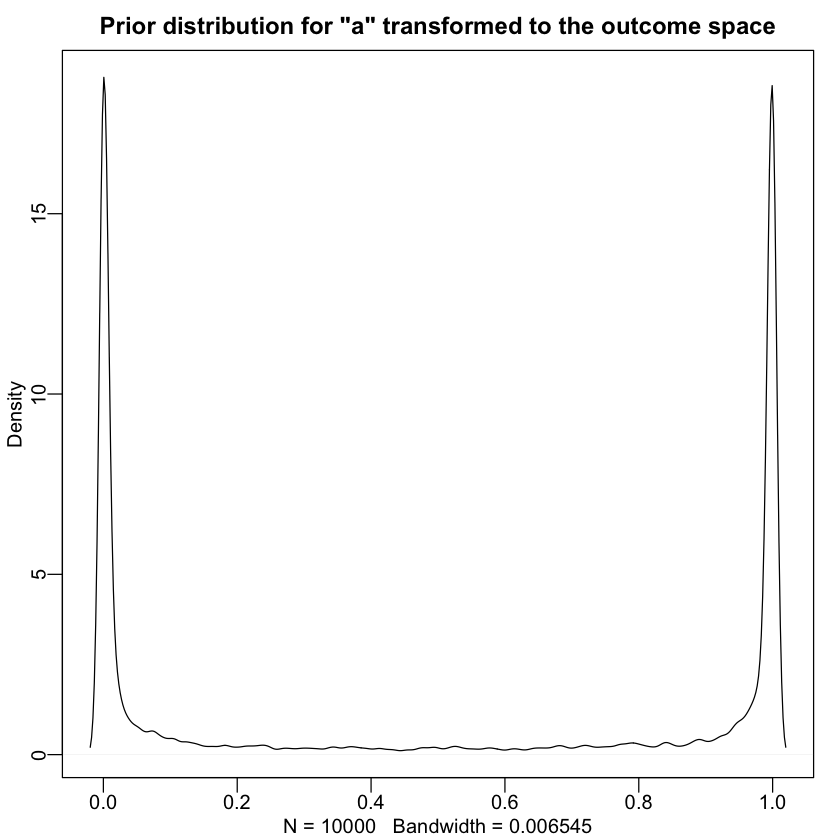

In [13]:
p <- inv_logit(prior$a)
dens(p, adj=0.1, main='Prior distribution for "a" transformed to the outcome space')

Looking at the prior distribution, before seeing the data, the model assumes that the chimps will always or never pull the left handle. So when using link functions, flat priors in the input space are not always flat priors in the outcome space.

### Another model with flat priors for a and b

In [16]:
m11.3 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p)  <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ), data=d
)
set.seed(1999)
prior <- extract.prior(m11.3, n=1e4)

In [19]:
str(prior)

List of 2
 $ a: num [1:10000(1d)] 1.099 -0.0567 1.8045 2.2047 0.2005 ...
 $ b: num [1:10000, 1:4] 0.117 -0.573 0.227 0.702 -0.449 ...
 - attr(*, "source")= chr "quap prior: 10000 samples from m11.3"


In [15]:
p <- sapply(1:4, function(k) inv_logit(prior$a + prior$b[,k]))

`p` is a matrix that holds samples for the probability of the chimpanzee to pull the left handle given one of four treatments. Probabilities are transformed to the outcome space.

In [21]:
head(p)

0.7713979,0.8049984,0.7137373,0.7676945
0.3476301,0.8053233,0.5288471,0.6541690
0.8840334,0.8988298,0.7884155,0.8116421
0.9481954,0.7352721,0.9323378,0.9408123
0.4383109,0.5773124,0.5566019,0.6365602
0.8007519,0.5696762,0.6684508,0.6935776


Now we want to know the average difference between the probability of the chimps to pull the left handle between treatments.

In [15]:
mean(abs(p[, 1] - p[, 2]))

[1] 0.09838663

The priors chosen in m11.3 are flat also in the transformed outcome space

### Hamiltonian Monte Carlo

In [22]:
dat_list <- list(
    pulled_left=d$pulled_left,
    actor=d$actor,
    treatment=as.integer(d$treatment)
)

In [23]:
options(mc.cores = parallel::detectCores())

In [27]:
m11.4 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ), data=dat_list, chains=4, log_lik=TRUE

)


SAMPLING FOR MODEL '82480dff1a626a42c2ca9de938d65b9d' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000114 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.49053 seconds (Warm-up)
Chain 1:                0.383273 seconds (Sampling)
Chain 1:   

In [28]:
precis(m11.4, depth=2)

,mean,sd,5.5%,94.5%,n_eff,Rhat4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.42878150,0.3342138,-0.94906783,0.11815917,672.2653,1.004924
a[2],3.93107324,0.7602115,2.83349513,5.22246780,1300.7738,1.001702
a[3],-0.72836642,0.3436646,-1.28993673,-0.17879044,844.5166,1.000267
a[4],-0.73107065,0.3446613,-1.30571195,-0.20065266,702.3799,1.003187
a[5],-0.42729720,0.3318995,-0.95139054,0.09454480,655.9572,1.002675
a[6],0.50386417,0.3420611,-0.05230458,1.04903793,665.2975,1.003914
a[7],1.97708463,0.4254668,1.28774926,2.65231310,682.8315,1.006864
b[1],-0.05687998,0.2875033,-0.50302618,0.41006017,602.2589,1.003733
b[2],0.46110431,0.2968568,-0.00997736,0.94910189,669.0463,1.002660


**Recap:**  
`n_eff` is an estimator for the number of independent samples you managed to get. Here, the number of efficient samples is much smaller (1/4th) than the actual number of samples, which means that the samples are autocorrelated to some degree.

`Rhat` measures whether the chain converges towards the true shape of the posterior. As it is almost 1 for all parameters, this is the case.

In [29]:
show(m11.4)

Hamiltonian Monte Carlo approximation
2000 samples from 4 chains

Sampling durations (seconds):
        warmup sample total
chain:1   0.49   0.38  0.87
chain:2   0.53   0.48  1.00
chain:3   0.51   0.41  0.92
chain:4   0.51   0.51  1.03

Formula:
pulled_left ~ dbinom(1, p)
logit(p) <- a[actor] + b[treatment]
a[actor] ~ dnorm(0, 1.5)
b[treatment] ~ dnorm(0, 0.5)
